# Wildfire Smoke Controls on Gross Primary Production in Central Canada

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# get Sam's stepwise selection function
import statsmodels.api as sm
%run ../lab02/Tutorial_2_2021_functions2.ipynb

# show full dataframes
pd.set_option('max_columns', None)

In [2]:
# get data
data_in = pd.read_csv("drf_timeseries.csv", parse_dates=True, index_col=1).drop("Unnamed: 0", axis=1)

## Select only the relevant months

This study is really only concerned with what goes on between May and September, as the vast majority of primary production (trees photosynthesizing/consuming CO2) and wildfire activity happen in the summer

In [19]:
# select just the growing/wildfire season (may-sept, inclusive)
growing_season = pd.DataFrame()
for month in [5,6,7,8,9]:
    growing_season = growing_season.append(data_in[data_in.index.month == month])

growing_season = growing_season.sort_values(by="datetime")
growing_season

# DEPRECIATED
#growing_season = pd.DataFrame()
#for month in [5,6,7,8,9]:
#for month in [1,2,3,4,5,6,7,8,9,10,11,12]:
    #growing_season = growing_season.append(data_in[pd.to_datetime(data_in['datetime']).dt.month == month])
#growing_season = growing_season.sort_values(by='datetime')
##growing_season["year"] = pd.to_datetime(data_in['datetime']).dt.year

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_865nm,AOD_779nm,AOD_675nm,AOD_667nm,AOD_620nm,AOD_560nm,AOD_555nm,AOD_551nm,AOD_532nm,AOD_531nm,AOD_510nm,AOD_500nm,AOD_490nm,AOD_443nm,AOD_440nm,AOD_412nm,AOD_400nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),AOD_681nm,AOD_709nm,Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,SH,LE,SLE,G,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,SW_DIF,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,RECO_PI,APAR,PPFD_DIF,FAPAR,ZL
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-08-05 00:00:00,0.0,NaN,0.043281,0.050140,NaN,NaN,0.056433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077186,NaN,NaN,0.084066,NaN,NaN,0.095379,0.109326,0.503352,NaN,NaN,377.728603,0.155769,NaN,16.754,238.260,2.5785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.5670,10.3795,0.0,61.7660,94.6780,NaN,NaN,0.7295,NaN,NaN,-38.485,0.000,0.06,NaN,0.000,0.105,335.240,373.680,NaN,NaN,NaN,1.6125,NaN,NaN
2005-08-05 01:00:00,0.0,NaN,0.041713,0.049306,NaN,NaN,0.055380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.077047,NaN,NaN,0.083923,NaN,NaN,0.094999,0.110109,0.510514,NaN,NaN,377.707512,0.155787,NaN,16.437,238.760,1.8935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.2685,10.1695,0.0,60.0260,94.6620,NaN,NaN,0.7475,NaN,NaN,-35.440,-0.005,0.19,NaN,0.000,-0.005,334.600,370.220,NaN,NaN,NaN,1.5790,NaN,NaN
2005-08-05 02:00:00,0.0,NaN,0.037905,0.045268,NaN,NaN,0.050330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070703,NaN,NaN,0.075927,NaN,NaN,0.086224,0.100517,0.493424,NaN,NaN,377.680050,0.155811,NaN,16.347,248.315,2.3990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9970,9.9720,0.0,59.3995,94.6285,NaN,NaN,0.7550,17.0,27.47,-30.630,0.000,0.35,NaN,0.000,-0.045,337.985,369.005,NaN,NaN,NaN,1.6050,NaN,NaN
2005-08-05 03:00:00,0.0,NaN,0.034070,0.040381,NaN,NaN,0.044884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063583,NaN,NaN,0.067235,NaN,NaN,0.077404,0.091669,0.470614,NaN,NaN,377.652588,0.155835,NaN,16.077,252.895,1.8860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.7580,9.7935,0.0,60.1995,94.5740,NaN,NaN,0.7275,NaN,NaN,-45.005,0.000,0.00,NaN,0.000,-0.120,320.270,365.400,NaN,NaN,NaN,1.5550,NaN,NaN
2005-08-05 04:00:00,0.0,NaN,0.032243,0.038891,NaN,NaN,0.043012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060868,NaN,NaN,0.063953,NaN,NaN,0.075606,0.089504,0.507524,NaN,NaN,377.623732,0.155859,NaN,15.396,232.210,0.8960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.5185,9.6225,0.0,60.8120,94.5105,NaN,NaN,0.6855,NaN,NaN,-46.400,0.160,-0.02,NaN,0.005,-0.290,314.705,361.375,NaN,NaN,NaN,1.8040,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-14 19:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 20:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14 21:00:00,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Find which measurements have the most complete data

In [20]:
# check data for completeness
def check_complete(data_in):
    """
    Prints out the percentage of non-NaN values in a dataset
    """
    data_len = np.shape(data_in)[0]
    for key in data_in.keys():
        if key != "datetime":
            not_nans = np.shape((data_in[np.isnan(data_in[key]) == False]))[0]
            completeness = not_nans / data_len * 100
            print(f"{key}:  {round(completeness,2)} %")
    return None
 

def keep_complete(data_in, thres):
    """
    returns a dataframe that contains a percentage of non-NaNs above
    a specified threshhold
    """
    data_out = pd.DataFrame()
    data_len = np.shape(data_in)[0]
    for key in data_in.keys():
        if key != "datetime":
            not_nans = np.shape((data_in[np.isnan(data_in[key]) == False]))[0]
            completeness = not_nans / data_len * 100
            if completeness >= thres:
                data_out[key] = data_in[key]
    return data_out

In [21]:
check_complete(growing_season)

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_865nm:  0.0 %
AOD_779nm:  0.0 %
AOD_675nm:  6.44 %
AOD_667nm:  0.0 %
AOD_620nm:  0.0 %
AOD_560nm:  0.0 %
AOD_555nm:  0.0 %
AOD_551nm:  0.0 %
AOD_532nm:  0.0 %
AOD_531nm:  0.0 %
AOD_510nm:  0.0 %
AOD_500nm:  5.51 %
AOD_490nm:  0.0 %
AOD_443nm:  0.0 %
AOD_440nm:  6.32 %
AOD_412nm:  0.0 %
AOD_400nm:  0.0 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
AOD_681nm:  0.0 %
AOD_709nm:  0.0 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
SH:  0.0 %
LE:  34.41 %
SLE:  0.0 %
G:  0.0 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
SW_DIF:  0.0 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
RECO_PI:  4.32 %
AP

Pretty dismal. We need the AOD data, so set a cutoff at 5%. We can hopefully interpolate the rest

In [22]:
data = keep_complete(growing_season, 4.9)
check_complete(data) # see if that worked

smoke:  98.84 %
AOD_1640nm:  5.23 %
AOD_1020nm:  6.23 %
AOD_870nm:  6.45 %
AOD_675nm:  6.44 %
AOD_500nm:  5.51 %
AOD_440nm:  6.32 %
AOD_380nm:  6.43 %
AOD_340nm:  6.38 %
Precipitable_Water(cm):  6.44 %
Ozone(Dobson):  6.45 %
NO2(Dobson):  6.45 %
USTAR:  35.13 %
TA:  36.0 %
WD:  36.01 %
WS:  36.02 %
NEE_PI:  26.2 %
FC:  34.41 %
SC:  34.61 %
H:  34.89 %
LE:  34.41 %
TS_1:  36.02 %
TS_2:  36.02 %
P:  36.63 %
RH:  35.81 %
PA:  36.6 %
CO2_1:  34.64 %
CO2_2:  27.2 %
VPD_PI:  35.81 %
SWC_1:  9.05 %
SWC_2:  9.05 %
NETRAD:  35.51 %
PPFD_IN:  36.57 %
SW_IN:  35.65 %
PPFD_OUT:  34.95 %
SW_OUT:  35.49 %
LW_IN:  36.0 %
LW_OUT:  35.93 %
H2O:  34.64 %
PPFD_DIF:  34.87 %


## Interpolation

Now, go through each individual measurement and hand-tune the pandas interpolation scheme to come up with something realistic (If this can't be achieved, toss the whole column). There is a balance here, we are trying to maximize coverage where all columns are finite (not NaNs, so we can perform PCA on as big of dataset as possible), without dangerously extending data beyond what is physical.

### AOD Data

Physical intuition tells us that smoke events operate on a scale of hours to weeks. We can maybe therefore safely interpolate up to several days worth of NaNs before getting into trouble

In [8]:
# get all the AOD columns that survived the purge
aod_list = []
for key in data.keys():
    if "AOD" in key:
        aod_list.append(key)
        print(key)

AOD_1640nm
AOD_1020nm
AOD_870nm
AOD_675nm
AOD_500nm
AOD_440nm
AOD_380nm
AOD_340nm


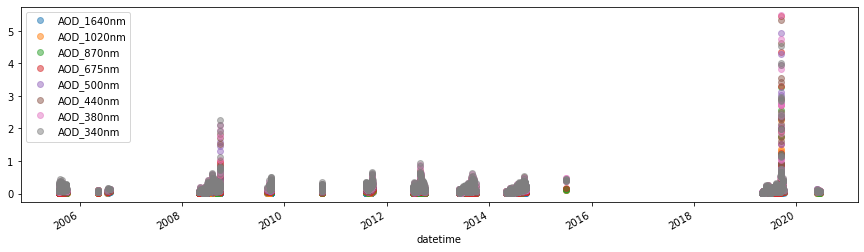

In [30]:
data = keep_complete(growing_season, 4.9) # reset it
# peek at the raw AOD data. How big of gaps am I willing to try to fill?
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

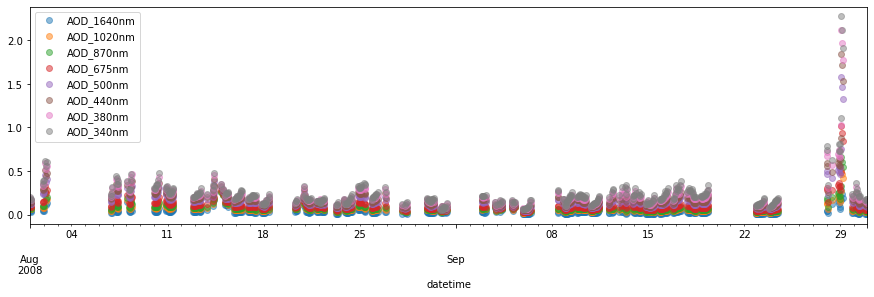

In [31]:
# enhance...
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

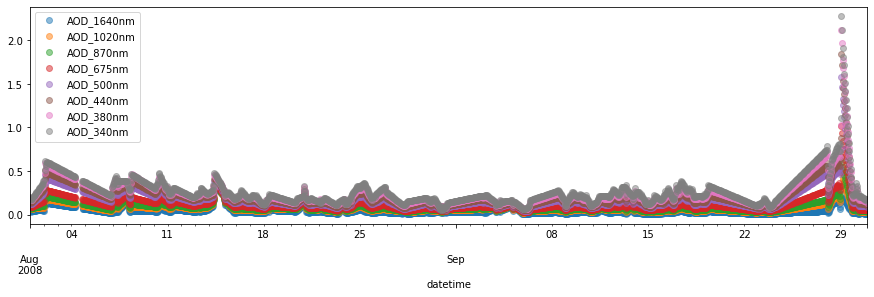

In [32]:
# interpolate with a limit of 48 hour gaps between real data points
data[aod_list] = data[aod_list].interpolate(method='time', limit=48, limit_direction='both')

# re-plot
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list]['2008-08-01':'2008-09-30'].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

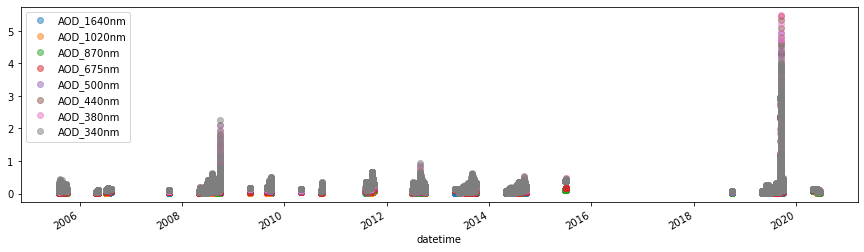

In [34]:
# zoom out again
fig, ax = plt.subplots(figsize=(15,4))
data[aod_list].plot(marker='o', linestyle="none", alpha=0.5, ax=ax);

48 hours of interpolation will massively increase the amount of viable data (remember, we can't perform PCA on data where *any* of the elements are NaN) while maintaining some sort of realism. We can expect whatever smoke/pollutant/synoptic weather pattern to persist for $\approx$ 48 hours (or at least we hope so).



<AxesSubplot:xlabel='datetime'>

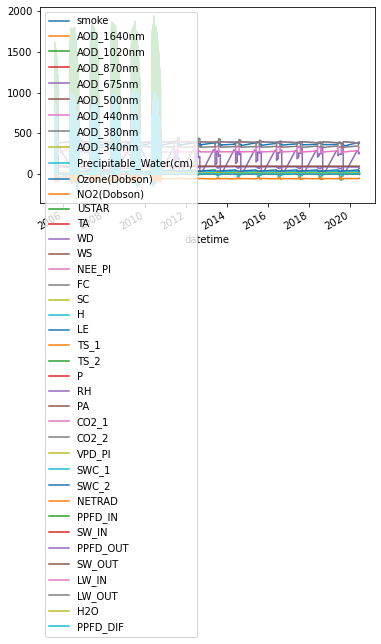

In [14]:
# Blanket interpolate all data using the same scheme (this is a bad idea)
data_interp = data.interpolate(method='linear')#.dropna()
data_interp.plot()

In [15]:
# after we finish messing about with interpolations, drop all rows that still have missing data
data_complete = data_interp.dropna()
data_complete

,smoke,AOD_1640nm,AOD_1020nm,AOD_870nm,AOD_675nm,AOD_500nm,AOD_440nm,AOD_380nm,AOD_340nm,Precipitable_Water(cm),Ozone(Dobson),NO2(Dobson),USTAR,TA,WD,WS,NEE_PI,FC,SC,H,LE,TS_1,TS_2,P,RH,PA,CO2_1,CO2_2,VPD_PI,SWC_1,SWC_2,NETRAD,PPFD_IN,SW_IN,PPFD_OUT,SW_OUT,LW_IN,LW_OUT,H2O,PPFD_DIF
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-05-10 19:00:00,0.0,0.033305,0.049200,0.056298,0.063188,0.079390,0.088104,0.102384,0.112820,0.312549,363.517738,0.089628,0.0570,11.2765,93.335,0.8805,-0.118500,-0.2075,0.0895,-0.6235,3.8780,1.4135,0.5935,0.0,34.7445,95.3610,385.00,386.10,0.8725,24.81500,34.78075,-5.800,83.115,37.825,2.83,2.380,327.635,368.885,4.7090,24.618000
2007-05-10 20:00:00,0.0,0.033303,0.049197,0.056295,0.063185,0.079387,0.088101,0.102380,0.112815,0.312490,363.510514,0.089622,0.0675,10.8755,211.190,1.4695,-0.054000,-0.1325,0.3020,-0.0290,1.4335,1.4115,0.5930,0.0,36.4595,95.3800,385.55,386.80,0.8275,24.95000,34.90050,-27.350,17.885,8.795,0.64,0.755,324.805,360.195,4.7660,24.401000
2007-05-10 21:00:00,0.0,0.033300,0.049194,0.056291,0.063183,0.079384,0.088098,0.102377,0.112811,0.312431,363.503290,0.089615,0.0515,9.8475,166.660,1.3790,0.112889,0.2880,0.5750,-3.0745,3.5980,1.3690,0.5770,0.0,42.1000,95.4140,387.40,388.90,0.7050,25.08500,35.02025,-40.180,0.340,-0.125,0.04,-0.060,309.630,349.735,5.0995,24.224000
2007-05-10 22:00:00,0.0,0.033298,0.049191,0.056288,0.063180,0.079382,0.088096,0.102374,0.112806,0.312372,363.496066,0.089608,0.0480,8.9750,99.205,0.6430,0.279778,-0.0850,-0.0325,0.6590,-0.9375,1.2780,0.5440,0.0,47.8850,95.4215,388.35,390.05,0.5975,25.22000,35.14000,-53.890,-0.025,-0.675,0.01,-0.160,286.340,339.710,5.4555,23.951286
2007-05-10 23:00:00,0.0,0.033295,0.049188,0.056285,0.063177,0.079379,0.088093,0.102370,0.112801,0.312312,363.488843,0.089602,0.0520,8.0710,78.385,1.4845,0.446667,0.1450,0.6860,-1.5055,0.3975,1.1420,0.4930,0.0,50.2855,95.4130,389.65,391.05,0.5365,25.27275,35.19250,-62.470,0.005,-0.405,0.01,-0.370,264.565,327.000,5.4055,23.678571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30 19:00:00,0.0,0.031276,0.040128,0.043634,0.053990,0.090500,0.090809,0.109523,0.114268,1.289717,344.984525,0.181482,0.0335,6.3890,7.815,1.1620,0.994000,0.1320,-0.4370,-0.4285,-0.1495,7.5730,7.5450,0.0,85.4865,95.5415,392.50,394.20,0.1405,21.21000,35.87100,-57.435,0.000,0.155,-0.02,-0.265,270.750,328.605,8.8190,0.135000
2019-09-30 20:00:00,0.0,0.030738,0.039467,0.042881,0.052954,0.088816,0.088864,0.107081,0.111582,1.281266,344.960217,0.181482,0.0335,6.3890,7.815,1.1620,0.994000,0.1320,-0.4370,-0.4285,-0.1495,7.5730,7.5450,0.0,85.4865,95.5415,392.50,394.20,0.1405,21.21000,35.87100,-57.435,0.000,0.155,-0.02,-0.265,270.750,328.605,8.8190,0.135000
2019-09-30 21:00:00,0.0,0.030201,0.038805,0.042129,0.051918,0.087131,0.086919,0.104639,0.108895,1.272815,344.935908,0.181483,0.0335,6.3890,7.815,1.1620,0.994000,0.1320,-0.4370,-0.4285,-0.1495,7.5730,7.5450,0.0,85.4865,95.5415,392.50,394.20,0.1405,21.21000,35.87100,-57.435,0.000,0.155,-0.02,-0.265,270.750,328.605,8.8190,0.135000


In [16]:
###################################################
# choose which version of the dataset to use here #
###################################################

#data = data_complete.drop("datetime", axis=1)
data = data_interp.drop("datetime", axis=1).dropna()

KeyError: "['datetime'] not found in axis"

## Part 2: Try PCA 

In [ ]:
#data = data_complete.drop("datetime", axis=1)
data = data_interp.drop("datetime", axis=1).dropna()

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
PCs = pca.fit_transform(data)
eigvecs = pca.components_
fracVar = pca.explained_variance_ratio_

In [ ]:
#plot fraction of variance explained by each mode
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(range(len(fracVar)),fracVar)
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by All Modes')

plt.subplot(1,2,2)
n_modes_show = 10
plt.scatter(range(n_modes_show),fracVar[:n_modes_show])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained by First ' + str(n_modes_show) + ' Modes')

plt.tight_layout()

plt.show()

In [ ]:
plt.plot(PCs[...,:4]);

PCA works properly. What are the biggest contributors to the leading modes?

## Multiple Linear Regression

Perform MLR on the PCs to create a predictive model with inputs

**PCs $\rightarrow$ CO2 Fluxes**

or, if we do rotated PCA:

**smoke, PCs $\rightarrow$ CO2 Fluxes**

## 1) MLR with the PCs

In [ ]:
# perform MLR with the columns of the PCs
### normalize the PCs first ###
### only use a few PCs
### separate carbon flux outputs ###


# assign predictors and predictands
X = pd.DataFrame(PCs)
Y = data["FC"]

# Do MLR
model = LinearRegression().fit(X, Y)
ypred_MLR = model.predict(X)  # y predicted by MLR
#intercept_MLR = model.intercept_[0]  # intercept predicted by MLR
coef_MLR = model.coef_.flatten()  # regression coefficients in MLR model
R2_MLR = model.score(X, Y)  # R-squared value from MLR model

# Display the results
for i, coef in enumerate(coef_MLR):
    print(f"PC{i}: {coef}")

## 2) MLR With the Regular Dataframe

In [ ]:
# assign predictors and predictands
X = data.drop("FC", axis=1)
Y = data["FC"]

# Do MLR
model = LinearRegression().fit(X, Y)
ypred_MLR = model.predict(X)  # y predicted by MLR
#intercept_MLR = model.intercept_[0]  # intercept predicted by MLR
coef_MLR = model.coef_.flatten()  # regression coefficients in MLR model
R2_MLR = model.score(X, Y)  # R-squared value from MLR model

# Display the results
for col, coef in zip(data.keys(), coef_MLR):
    print(f"{col}: {coef}")

## To Do

- Interpolate all columns, eyeball-optimizing between coverage and faithful interpolated values
- chop out dates and outputs, perform PCA on everything else
- try step 2 again, this time grouping on smoke level. Are the leading modes different?


- Try it again with rotated PCA
- Write up the presentation
